In [53]:
import torch
from torch import nn
from torchinfo import summary

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy  as np

import os
import glob

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Read Raw data

In [3]:
_data_file = os.path.join("..", "data", "jikken1", "raw", "*.csv")
data_files = sorted(glob.glob(_data_file))

data_files

['../data/jikken1/raw/Conv-sensorA-1.csv',
 '../data/jikken1/raw/Conv-sensorB-1.csv',
 '../data/jikken1/raw/Conv-sensorC-1.csv',
 '../data/jikken1/raw/Conv-sensorD-1.csv',
 '../data/jikken1/raw/Conv-sensorE-1.csv']

In [4]:
data_list = []

for data_file in data_files:
    identifier = os.path.basename(data_file)[-7]
    
    df = pd.read_csv(data_file, encoding="shift-jis")
    
    df_nona = df.dropna(subset="label")
    print("***df_nona first", df_nona.index[0])
    
    df_filter_start_na = df.iloc[df_nona.index[0]:df_nona.index[-1], :]
    
    df_filter_start_na = df_filter_start_na.reset_index(drop=True)
    
    label = df_filter_start_na.loc[:, "label"]
    df_filter_start_na = df_filter_start_na.drop(["ts", "label"], axis=1)
    
    df_filter_start_na = df_filter_start_na.rename(lambda x: x + f"_{identifier}", axis=1)
    
    print("len(df_filter_start_na)", len(df_filter_start_na))
  
    data_list.append(df_filter_start_na)

data_df = pd.concat(data_list, axis=1)
data_df["label"] = label

data_df

***df_nona first 25422
len(df_filter_start_na) 90432
***df_nona first 24679
len(df_filter_start_na) 90432
***df_nona first 24396
len(df_filter_start_na) 90432
***df_nona first 24161
len(df_filter_start_na) 90432
***df_nona first 23883
len(df_filter_start_na) 90432


,ax_A,ay_A,az_A,gx_A,gy_A,gz_A,ax_B,ay_B,az_B,gx_B,...,gx_D,gy_D,gz_D,ax_E,ay_E,az_E,gx_E,gy_E,gz_E,label
0,-7935,1954,3465,-2788,323,-3586,-11585,-2828,1490,-6382,...,-4613,10980,-530,-8155,1505,3740,120,-1570,3440,階段降り
1,-7847,1998,3445,-2855,158,-3629,-11443,-2667,1373,-7248,...,-5308,11516,-280,-7842,1520,3598,241,-1710,3196,階段降り
2,-7647,2051,3387,-3008,-48,-3592,-11199,-2462,1299,-8083,...,-5363,11230,-129,-7432,1407,3462,223,-1685,2915,階段降り
3,-7495,2100,3309,-3124,-310,-3531,-10965,-2296,1021,-8907,...,-6266,10797,194,-7208,1354,3354,34,-1649,2635,階段降り
4,-7315,1954,3245,-3191,-548,-3421,-10652,-2233,782,-9650,...,-7906,11059,322,-7017,1158,3261,-264,-1673,2366,階段降り
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90427,-6387,6016,4700,199,-353,-147,-5169,-6183,5640,-16,...,69,-92,-189,-8550,1476,4765,205,76,-66,座っている
90428,-6358,6031,4749,278,-487,-196,-5145,-6197,5645,20,...,44,-99,-183,-8536,1476,4800,217,45,-108,座っている
90429,-6280,5997,4847,351,-554,-202,-5174,-6188,5577,130,...,-4,-129,-183,-8497,1529,4721,205,45,-120,座っている
90430,-6265,6011,4837,400,-652,-214,-5193,-6144,5543,160,...,-29,-123,-219,-8511,1515,4707,205,15,-169,座っている


In [5]:
label_list = ['歩いている', '立っている', '走っている', '階段降り', '階段上り', '座っている']
eng_label_dict = dict(zip(
    ['歩いている', '立っている', '走っている', '階段降り', '階段上り', '座っている'],
    ['Walking', 'Standing', 'Jogging', 'DownStair', 'Upstair', 'Sit']
))

eng_label_list = [eng_label_dict[i] for i in label_list]

## Normalize over the dataframe

In [6]:
# although we should fit transform the train dataset and transform the test dataset, 
# we will choose the easy way here

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

label_ = data_df['label']

data_ = sc.fit_transform(data_df.drop(['label'], axis=1))
data_df = pd.DataFrame(data_, columns=data_df.drop(['label'], axis=1).columns)
data_df["label"] = label_

In [46]:
data_feature_number = data_.shape[1]
data_feature_number

30

In [7]:
data_df.head()

,ax_A,ay_A,az_A,gx_A,gy_A,gz_A,ax_B,ay_B,az_B,gx_B,...,gx_D,gy_D,gz_D,ax_E,ay_E,az_E,gx_E,gy_E,gz_E,label
0,0.000113,-0.348720,0.512753,-0.323051,0.042030,-0.278652,-0.654823,0.260838,-0.125440,-0.708131,...,-0.197855,0.803098,-0.010719,0.111749,0.068531,-0.175021,-0.024510,-0.373796,1.099770,階段降り
1,0.014841,-0.342744,0.507418,-0.329221,0.020964,-0.282169,-0.631983,0.282566,-0.160042,-0.803607,...,-0.228361,0.841314,0.031078,0.176727,0.073930,-0.221983,0.002579,-0.409128,1.025970,階段降り
2,0.048312,-0.335546,0.491945,-0.343311,-0.005336,-0.279143,-0.592738,0.310231,-0.181927,-0.895666,...,-0.230776,0.820923,0.056323,0.261842,0.033257,-0.266960,-0.001450,-0.402818,0.940979,階段降り
3,0.073750,-0.328892,0.471137,-0.353994,-0.038785,-0.274154,-0.555102,0.332633,-0.264143,-0.986512,...,-0.270412,0.790050,0.110324,0.308344,0.014181,-0.302677,-0.043764,-0.393733,0.856291,階段降り
4,0.103873,-0.348720,0.454063,-0.360164,-0.069171,-0.265158,-0.504759,0.341135,-0.334826,-1.068428,...,-0.342398,0.808731,0.131723,0.347996,-0.056367,-0.333433,-0.110481,-0.399790,0.774929,階段降り


## Segmentation

In [8]:
def segment(data_df, label_list, Window_size = 200, over_lap = 0.5, margin = 300):
    data_df_index_list = []
    index_label_list = []
    
    overlap_data = Window_size * over_lap

    index = 0
    loop = 0
    
    while index < data_df.shape[0]:
        if pd.isna(data_df['label'][index]):
            index = index + 1
            continue

        count = 0
        while count < margin:
            count, index = count + 1, index + 1

        if index  >= data_df.shape[0]: break
        current_label = data_df.loc[index, 'label']

        while not pd.isna(data_df['label'][index + Window_size]) and data_df['label'][index + Window_size] == current_label:
#                 signal_data = data_df.iloc[index: index + Window_size, :]

            # Each data will be at size column(6 x 5 = 30) x Window_size
            # achieved by `data_df.loc[index: index + self.Window_size, :]` for index in data_df_index_list.
            # Data label will be `data_df.loc[index + self.Window_size, "label"]` for index in data_df_index_list.
            data_df_index_list.append(index)
            index = index + Window_size

            # add label of the last row of sequence
            index_label_list.append(label_list.index(data_df['label'][index]))

            index = index - int(overlap_data)
            if index + Window_size >= data_df.shape[0]: break
                
    return data_df_index_list, index_label_list

In [9]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, data_df, label_list, data_df_index_list, Window_size=200):

        self.data_df = data_df
        self.labels = label_list
        self._data_df_index_list = data_df_index_list
        self.Window_size = Window_size
        
    def __len__(self):
        return len(self._data_df_index_list)
    
    def __getitem__(self, idx):
        index = self._data_df_index_list[idx]
        x = self.data_df.iloc[index: index + self.Window_size, :].drop(["label"], axis=1).values
        label = self.labels.index(self.data_df["label"][index + self.Window_size])
        
        return x, label

In [10]:
## testing
data_df_index_list, index_label_list = segment(data_df, label_list)
dataset = CustomDataset(data_df, label_list=label_list, data_df_index_list=data_df_index_list)
loader = DataLoader(dataset)
next(iter(loader))

[tensor([[[-1.1317,  0.1990, -0.1790,  ...,  0.4367, -1.0277, -0.5967],
          [-1.1071,  0.2188, -0.1659,  ...,  0.4503, -0.9553, -0.7867],
          [-1.0589,  0.1612, -0.2155,  ...,  0.4830, -0.8260, -0.9397],
          ...,
          [ 0.1251, -0.3368, -0.0968,  ..., -0.7564, -0.5969,  0.5705],
          [ 0.1146, -0.3063, -0.1008,  ..., -0.8750, -0.5507,  0.5556],
          [ 0.1129, -0.2831, -0.0643,  ..., -0.9803, -0.4768,  0.5224]]],
        dtype=torch.float64),
 tensor([3])]

## KFold setup

In [11]:
# the dataset label and index list correspond to each other
dataset_label_array = np.array(index_label_list)
dataset_index_list = np.array(data_df_index_list)

#ラベル名ごとにカウント
index_data_all = []

# separate dataset_index_list and fill into index_data_all base on the label in dataset_label_array
# the order of index_data_all will follow label_list index
for activity_label in label_list:
    print("activity_label:", activity_label)
    
    one_activity_data = dataset_index_list[dataset_label_array == label_list.index(activity_label)]
    index_data_all.append(one_activity_data)

index_data_all

activity_label: 歩いている
activity_label: 立っている
activity_label: 走っている
activity_label: 階段降り
activity_label: 階段上り
activity_label: 座っている


[array([29689, 29789, 29889, 29989, 30089, 30189, 30289, 30389, 30489,
        30589, 30689, 30789, 30889, 30989, 31089, 31189, 31289, 31389,
        31489, 31589, 31689, 31789, 31889, 31989, 32089, 32189, 32289,
        32389, 32489, 32589, 32689, 32789, 32889, 32989, 33089, 33189,
        33289, 33389, 33489, 33589, 33689, 33789, 33889, 33989, 34089,
        34189, 34289, 34389, 34489, 34589, 34689, 34789, 34889, 34989,
        35089, 35189, 35289, 35389, 76878, 76978, 77078, 77178, 77278,
        77378, 77478, 77578, 77678, 77778, 77878, 77978, 78078, 78178,
        78278, 78378, 78478, 78578, 78678, 78778, 78878, 78978, 79078,
        79178, 79278, 79378, 79478, 79578, 79678, 79778, 79878, 79978,
        80078, 80178, 80278, 80378, 80478, 80578, 80678, 80778, 80878,
        80978, 81078, 81178, 81278, 81378, 81478, 81578, 81678, 81778,
        81878, 81978, 82078, 82178, 82278, 82378, 82478, 82578, 82678,
        82778, 82878]),
 array([15478, 15578, 15678, 15778, 15878, 15978, 160

In [12]:
from sklearn.model_selection import KFold

n_split = 10

#KFoldの設定(10個に分割)
kf = KFold(n_splits = n_split, shuffle = True, random_state = 42)

# k_index_list (size: label number (6) x kfold number (10) x train or test (2)) 
k_index_list = []

for activity_data in index_data_all:
    k_index_list.append(list(kf.split(activity_data)))
    
k_index_list[0][0] 

(array([  0,   1,   2,   3,   5,   6,   7,   8,   9,  11,  12,  13,  14,
         15,  16,  17,  19,  20,  21,  22,  23,  24,  25,  27,  28,  29,
         30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  57,
         58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  70,  71,
         72,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
         86,  87,  88,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114,
        115, 116, 118]),
 array([  4,  10,  18,  26,  45,  56,  69,  73,  89,  90, 112, 117]))

In [13]:
kfold_train_test_index_list = []

for k in range(n_split):
#     train test for 1 fold
    train_x, val_x, test_x = [], [], []

    for i, activity_data in enumerate(index_data_all):

        activity_train_index, activity_test_index = \
            activity_data[ k_index_list[i][k][0] ], activity_data[ k_index_list[i][k][1] ]
        
#         activity_y_train, activity_y_test = label_all[i][ k_index_list[i][k][0] ], label_all[i].values[ k_index_list[i][k][1] ]

        activity_train, activity_val = train_test_split(activity_train_index, random_state=42, test_size=0.15)

        train_x.append(activity_train)
        val_x.append(activity_val)
        test_x.append(activity_test_index)

    train_x = np.concatenate(train_x, axis=0)
    val_x = np.concatenate(val_x, axis=0)
    test_x = np.concatenate(test_x, axis=0)

    kfold_train_test_index_list.append((train_x, val_x, test_x))

In [14]:
kfold_train_test_index_list

[(array([79578, 78278, 34389, 31089, 33689, 78578, 32689, 32189, 33189,
         77278, 81678, 31389, 34589, 80978, 80878, 30789, 33389, 78678,
         82178, 32889, 34089, 30289, 76978, 80178, 33989, 33589, 31589,
         79878, 33489, 30489, 34489, 78178, 82878, 32789, 31889, 81878,
         81178, 32589, 77878, 35089, 31189, 32489, 29989, 31689, 33889,
         30589, 80378, 30389, 78778, 81378, 80578, 77078, 35189, 79078,
         34789, 79178, 77778, 82478, 80478, 34289, 77478, 34989, 82578,
         77378, 79378, 33289, 82078, 77578, 78078, 81078, 33789, 32989,
         81578, 29789, 76878, 32089, 29889, 32389, 80778, 81778, 79278,
         80678, 80278, 31989, 77678, 78978, 31289, 81278, 35389, 82378,
         65889, 19278, 16978, 18478, 67889, 63189, 17978, 65489, 20678,
         64989, 17278, 20478, 20278, 16678, 66489, 16878, 68289, 65689,
         18678, 65789, 16078, 63889, 63289, 20178, 19578, 17378, 64389,
         19378, 16278, 20578, 64589, 64689, 18578, 17678, 66389,

In [15]:
## test

# Create train dataset and test dataset for the first activity in label_list
print("label_list[0]", label_list[0])

train_data_df_index_list, val_data_df_index_list, test_data_df_index_list = kfold_train_test_index_list[0]

train_dataset = CustomDataset(data_df, label_list, train_data_df_index_list)
val_dataset = CustomDataset(data_df, label_list, val_data_df_index_list)
test_dataset = CustomDataset(data_df, label_list, test_data_df_index_list)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=8,
    num_workers=0, # number of subprocesses to use for data loading
    shuffle=True)

val_dataloader = DataLoader(
    train_dataset, 
    batch_size=8,
    num_workers=0, # number of subprocesses to use for data loading
    shuffle=False)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=0, # number of subprocesses to use for data loading
    shuffle=False)

next(iter(train_dataloader))

label_list[0] 歩いている


[tensor([[[ 1.5123e-01, -3.0173e-01, -1.9340e-01,  ...,  4.2035e-01,
           -2.3864e+00, -5.9128e-01],
          [ 1.7098e-01, -3.2360e-01, -1.6992e-01,  ...,  4.0937e-01,
           -2.1634e+00, -1.1224e+00],
          [ 1.9056e-01, -3.5470e-01, -1.6458e-01,  ...,  3.5743e-01,
           -1.9526e+00, -1.4838e+00],
          ...,
          [ 3.4905e-01, -3.3147e-01,  2.2757e-01,  ...,  1.9902e+00,
            1.5694e-01,  3.1761e-01],
          [ 3.6210e-01, -3.4410e-01,  2.3798e-01,  ...,  2.4284e+00,
           -2.7815e-01,  2.9372e-01],
          [ 3.5641e-01, -3.4016e-01,  2.5478e-01,  ...,  2.1935e+00,
           -1.0984e+00,  1.4430e-01]],
 
         [[-7.3355e-02,  1.3665e-01, -6.5145e-01,  ..., -6.8168e-02,
            7.7881e-03,  5.5983e-02],
          [-7.2519e-02,  1.3733e-01, -6.3731e-01,  ..., -6.8168e-02,
            1.3845e-02,  6.8687e-02],
          [-7.5029e-02,  1.3462e-01, -6.3597e-01,  ..., -6.1451e-02,
            1.5359e-02,  6.6872e-02],
          ...,
    

## Model definition

In [36]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_size=128, input_size=30, output_size=6):
        super().__init__()
        self.rnn = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=2,
                          batch_first=True)
        
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * hidden_size, out_features=output_size)
        
    def forward(self, x):
        activation, _ = self.rnn(x)
        
        b, _, _ = activation.size()
        lstm_output = activation[:,-1,:].view(b,-1)
        seq_1_output = self.seq_1(lstm_output)
        seq_2_output = self.seq_2(lstm_output)
        
        output = torch.concat([lstm_output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output


In [37]:
model = LSTMModel()
summary(model)

Layer (type:depth-idx)                   Param #
LSTMModel                                --
├─LSTM: 1-1                              214,016
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       16,512
│    └─BatchNorm1d: 2-2                  256
│    └─Dropout1d: 2-3                    --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       16,512
│    └─BatchNorm1d: 2-6                  256
│    └─Dropout1d: 2-7                    --
│    └─ReLU: 2-8                         --
├─Sequential: 1-3                        --
│    └─Linear: 2-9                       16,512
│    └─BatchNorm1d: 2-10                 256
│    └─Dropout1d: 2-11                   --
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      16,512
│    └─BatchNorm1d: 2-14                 256
│    └─Dropout1d: 2-15                   --
│    └─ReLU: 2-16                        --
├─Linear: 1-4                            2,310

## Train step setup

In [38]:
%%writefile early_stopping_utils.py

# Inspired from https://github.com/Bjarten/early-stopping-pytorch
import numpy as np
import torch
import os


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.trace_func(f'EarlyStopping patience reached')
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        os.makedirs(os.path.dirname(self.path), exist_ok=True)
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

Overwriting early_stopping_utils.py


In [39]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.float().to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [40]:
def val_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.float().to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    return test_loss, test_acc

In [41]:
def test_step(model: torch.nn.Module, 
          dataloader: torch.utils.data.DataLoader):
    # Put model in eval mode
    model.eval() 
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.float().to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)

    return test_pred_labels, y

In [75]:
from tqdm.auto import tqdm
# import EarlyStopping
from early_stopping_utils import EarlyStopping


epochs = 200
batch_size = 1024

patience = 20
best_pt = "weights/best.pt"

all_test = []
all_pred = []
loss_all_folds = []

for i, (train_index, val_index, test_index) in enumerate(kfold_train_test_index_list):
    print(f"\n*************KFOLD {i + 1}*************")
    
    one_fold_loss = []

    train_dataset = CustomDataset(data_df, label_list, train_index)
    val_dataset = CustomDataset(data_df, label_list, val_index)
    test_dataset = CustomDataset(data_df, label_list, test_index)

    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=batch_size,
        num_workers=4, # number of subprocesses to use for data loading
        shuffle=True)
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=batch_size,
        num_workers=2, # number of subprocesses to use for data loading
        shuffle=False)
    
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=2, # number of subprocesses to use for data loading
        shuffle=False)
    
    model = LSTMModel(hidden_size=64, input_size=data_feature_number, output_size=len(label_list)).to(device)
    early_stopping = EarlyStopping(patience=patience, verbose=False, path=best_pt)

    # Setup loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        val_loss, val_acc = val_step(
            model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn)
        
        # Append train loss and val loss for plotting
        one_fold_loss.append([train_loss, val_loss])
        
#         print(
#             f"Epoch: {epoch+1} | "
#             f"train_loss: {train_loss:.4f} | "
#             f"train_acc: {train_acc:.4f} | "
#             f"val_loss: {test_loss:.4f} | "
#             f"val_acc: {test_acc:.4f}"
#         )
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print(f"Early stopping at epoch: {epoch+1}")
            break
            
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(best_pt))
    
    y_pred, y_true = test_step(model, test_dataloader)

    all_test.extend(y_true.cpu().numpy())
    all_pred.extend(y_pred.cpu().numpy())
    
    loss_all_folds.append(one_fold_loss)
        


*************KFOLD 1*************


  0%|          | 0/200 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20
EarlyStopping counter: 13 out of 20
EarlyStopping counter: 14 out of 20
EarlyStopping counter: 15 out of 20
EarlyStopping counter: 16 out of 20
EarlyStopping counter: 17 out of 20
EarlyStopping counter: 18 out of 20
EarlyStoppi

## Visualize the training process loss

In [84]:
# We will visualize loss graph for fold k

def visualize_loss_graph(one_fold_data,  title="Loss graph"):
    train_loss_list = list(map(lambda x: x[0], one_fold_data))
    val_loss_list = list(map(lambda x: x[1], one_fold_data))
    
    fig = plt.figure(figsize=(8,6))

    plt.plot(range(1,len(one_fold_data)+1),train_loss_list, label='Training Loss')
    plt.plot(range(1,len(one_fold_data)+1),val_loss_list,label='Validation Loss')
    plt.plot(np.argmin(val_loss_list) + 1, np.min(val_loss_list), 'ro', label='Stop point')

    plt.legend()
    plt.grid(True)

    plt.tight_layout()


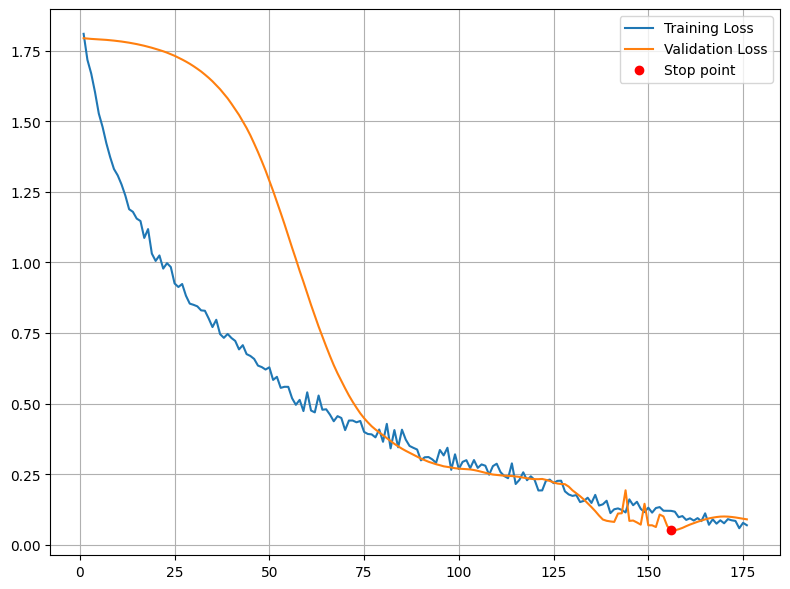

In [85]:
one_fold_data = loss_all_folds[0]
visualize_loss_graph(one_fold_data, title="Loss graph for first fold")

## Evaluation and metric testing

<Axes: >

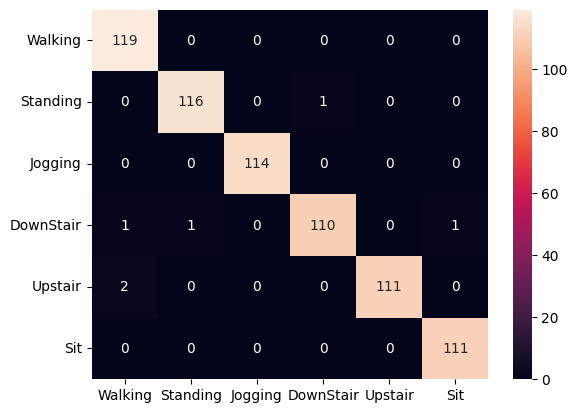

In [26]:
all_test_with_label = [label_list[i] for i in all_test]
all_pred_with_label = [label_list[i] for i in all_pred]

cf = confusion_matrix(all_test_with_label, all_pred_with_label, labels=label_list)
sns.heatmap(cf, annot=True, xticklabels=eng_label_list, yticklabels=eng_label_list, fmt='g')

In [27]:
print("precision_recall_fscore_support: ")
print()
print(*eng_label_list, sep=" "*4)
print(*precision_recall_fscore_support(all_test_with_label, all_pred_with_label, labels=label_list), sep="\n")

precision_recall_fscore_support: 

Walking    Standing    Jogging    DownStair    Upstair    Sit
[0.97540984 0.99145299 1.         0.99099099 1.         0.99107143]
[1.         0.99145299 1.         0.97345133 0.98230088 1.        ]
[0.98755187 0.99145299 1.         0.98214286 0.99107143 0.9955157 ]
[119 117 114 113 113 111]
